In [1]:
from datasets import load_dataset

ds = load_dataset("universeTBD/arxiv-bit-flip-cs.LG")

Generating train split:   0%|          | 0/100039 [00:00<?, ? examples/s]

In [2]:
ds

DatasetDict({
    train: Dataset({
        features: ['bit', 'flip', 'title', 'categories', 'abstract', 'authors', 'doi', 'id'],
        num_rows: 100039
    })
})

In [3]:
from datasets import load_dataset

hypo = load_dataset("charlieoneill/hypogen-data")

Generating train split:   0%|          | 0/46030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/709 [00:00<?, ? examples/s]

In [4]:
hypo

DatasetDict({
    train: Dataset({
        features: ['title', 'authors', 'abstract', 'year', 'venue', 'bit_flip_spark'],
        num_rows: 46030
    })
    test: Dataset({
        features: ['title', 'authors', 'abstract', 'year', 'venue', 'bit_flip_spark'],
        num_rows: 709
    })
})

In [6]:
from datasets import concatenate_datasets, DatasetDict
import pandas as pd

def normalize_authors(example):
    if isinstance(example['authors'], list):
        return {'authors': ', '.join(example['authors'])}
    return {'authors': str(example['authors'])}

# Normalize authors in each dataset
ds['train'] = ds['train'].map(normalize_authors)
hypo['train'] = hypo['train'].map(normalize_authors)
hypo['test'] = hypo['test'].map(normalize_authors)

# Convert to pandas DataFrames
df1 = ds['train'].to_pandas()
df2 = hypo['train'].to_pandas()
df3 = hypo['test'].to_pandas()

# Combine all dataframes
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Deduplicate based on title
deduplicated_df = combined_df.drop_duplicates(subset='title', keep='first')

# Convert back to a Dataset
from datasets import Dataset
final_dataset = Dataset.from_pandas(deduplicated_df)

# Create a new DatasetDict with the deduplicated dataset
final_dataset_dict = DatasetDict({'train': final_dataset})

# Print some information about the final dataset
print(f"Number of rows in final dataset: {len(final_dataset_dict['train'])}")
print(f"Features in final dataset: {final_dataset_dict['train'].features}")

Map:   0%|          | 0/100039 [00:00<?, ? examples/s]

Map:   0%|          | 0/46030 [00:00<?, ? examples/s]

Map:   0%|          | 0/709 [00:00<?, ? examples/s]

Number of rows in final dataset: 141518
Features in final dataset: {'bit': Value(dtype='string', id=None), 'flip': Value(dtype='string', id=None), 'title': Value(dtype='string', id=None), 'categories': Value(dtype='string', id=None), 'abstract': Value(dtype='string', id=None), 'authors': Value(dtype='string', id=None), 'doi': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None), 'year': Value(dtype='float64', id=None), 'venue': Value(dtype='string', id=None), 'bit_flip_spark': {'bit': Value(dtype='string', id=None), 'flip': Value(dtype='string', id=None), 'spark': Value(dtype='string', id=None)}, '__index_level_0__': Value(dtype='int64', id=None)}


In [21]:
features = [x for x in list(final_dataset.features.keys()) if x not in ['bit', 'flip', 'bit_flip_spark', '__index_level_0__']]
final_dataset = final_dataset.remove_columns(['bit', 'flip', 'bit_flip_spark', '__index_level_0__'])
final_dataset

Dataset({
    features: ['title', 'categories', 'abstract', 'authors', 'doi', 'id', 'year', 'venue'],
    num_rows: 141518
})

In [22]:
final_dataset.push_to_hub('charlieoneill/cs.LG')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/142 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/charlieoneill/cs.LG/commit/2074bc9c018085e0e3c94594c7928deaf5c377d6', commit_message='Upload dataset', commit_description='', oid='2074bc9c018085e0e3c94594c7928deaf5c377d6', pr_url=None, pr_revision=None, pr_num=None)

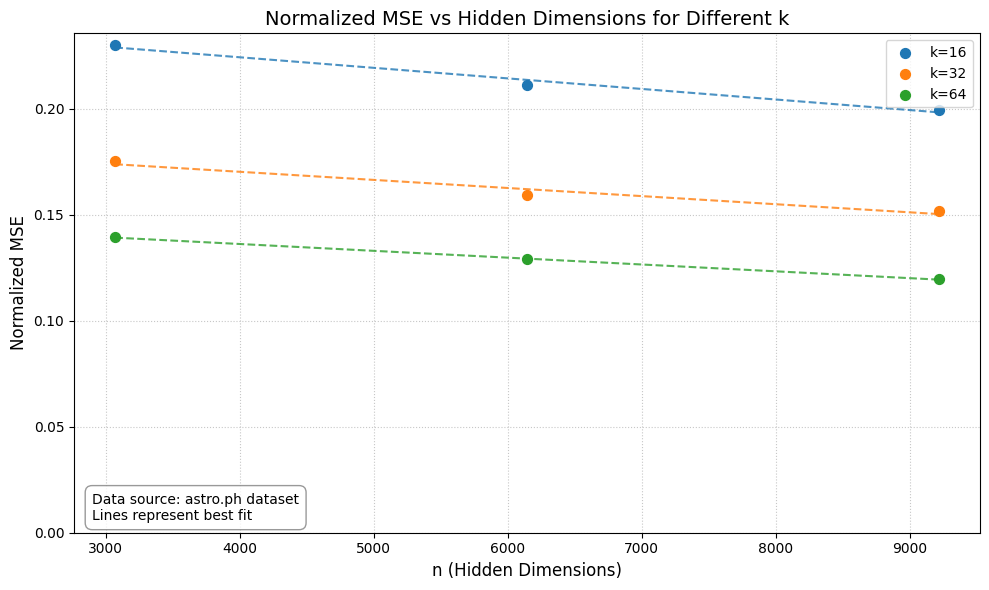

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_values = [16, 32, 64]
n_values = [3072, 6144, 9216]
mse_values = {
    16: [0.2300, 0.2113, 0.1994],
    32: [0.1751, 0.1594, 0.1516],
    64: [0.1393, 0.1290, 0.1195]
}

# Set up the plot
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Plot data and fit lines
for i, k in enumerate(k_values):
    x = n_values
    y = mse_values[k]
    
    # Plot scatter points
    plt.scatter(x, y, color=colors[i], s=50, zorder=3, label=f'k={k}')
    
    # Fit a line
    coeffs = np.polyfit(x, y, 1)
    poly = np.poly1d(coeffs)
    
    # Plot the line of best fit
    x_line = np.linspace(min(x), max(x), 100)
    plt.plot(x_line, poly(x_line), color=colors[i], linestyle='--', alpha=0.8)

# Customize the plot
plt.xlabel('n (Hidden Dimensions)', fontsize=12)
plt.ylabel('Normalized MSE', fontsize=12)
plt.title('Normalized MSE vs Hidden Dimensions for Different k', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend(fontsize=10)

# Set y-axis to start from 0
plt.ylim(bottom=0)

# Add a text box with information
plt.text(0.02, 0.02, 'Data source: astro.ph dataset\nLines represent best fit', 
         transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray', alpha=0.8))

# Adjust layout and display
plt.tight_layout()
plt.show()

## Abstract embeddings

In [30]:
import numpy as np
import pickle
import json
from typing import List
from dataclasses import dataclass
from tqdm import tqdm

@dataclass
class Document:
    id: str
    abstract: str
    #conclusions: str
    id: str
    title: str = None
    n_citation: int = None
    keywords: List[str] = None

# Load the full embeddings matrix
embeddings = np.load('../data/vector_store_csLG/embeddings_matrix.npy')

# Load the index mapping
with open('../data/vector_store_csLG/index_mapping.pkl', 'rb') as f:
    index_mapping = pickle.load(f)

# Load the documents
with open('../data/vector_store_csLG/documents.pkl', 'rb') as f:
    documents = pickle.load(f)

# Create lists to store the abstract embeddings and corresponding text
abstract_embeddings = []
abstract_texts = []
doc_ids = []

# Iterate through the index mapping to find abstract indices and corresponding text
for doc_id, mappings in tqdm(index_mapping.items()):
    if 'abstract' in mappings:
        abstract_index = mappings['abstract']
        abstract_embeddings.append(embeddings[abstract_index])
        
        # Find the corresponding document and extract the abstract text
        doc = next((d for d in documents if d.id == doc_id), None)
        if doc:
            abstract_texts.append(doc.abstract)
            doc_ids.append(doc_id)
        else:
            print(f"Warning: Document with ID {doc_id} not found.")

# Convert lists to numpy arrays
abstract_embeddings = np.array(abstract_embeddings)

print(f"Processed {len(abstract_embeddings)} abstract embeddings.")
print(f"Shape of abstract embeddings: {abstract_embeddings.shape}")
print(f"Length of abstract texts: {len(abstract_texts)}")
print(f"Length of document IDs: {len(doc_ids)}")

# Save the abstract embeddings
# np.save('../data/vector_store_csLG/abstract_embeddings.npy', abstract_embeddings)

# # Save the abstract texts and document IDs
# with open('../data/vector_store_csLG/abstract_texts.json', 'w') as f:
#     json.dump({
#         'doc_ids': doc_ids,
#         'abstracts': abstract_texts
#     }, f)

print("Saved abstract embeddings and texts.")

 11%|█         | 11048/99803 [00:01<00:15, 5633.36it/s]


KeyboardInterrupt: 

In [31]:
embeddings_path = '../data/embeddings/embeddings_final_csLG.pkl'

# Load the embeddings
with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)

In [34]:
len(list(embeddings.keys()))

99803

In [27]:
# Load abstract embeddings
abstract_embeddings = np.load('../data/vector_store_csLG/abstract_embeddings.npy')

In [28]:
abstract_embeddings.shape

(99803, 1536)

/Users/charlesoneill/miniconda3/envs/saerch/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


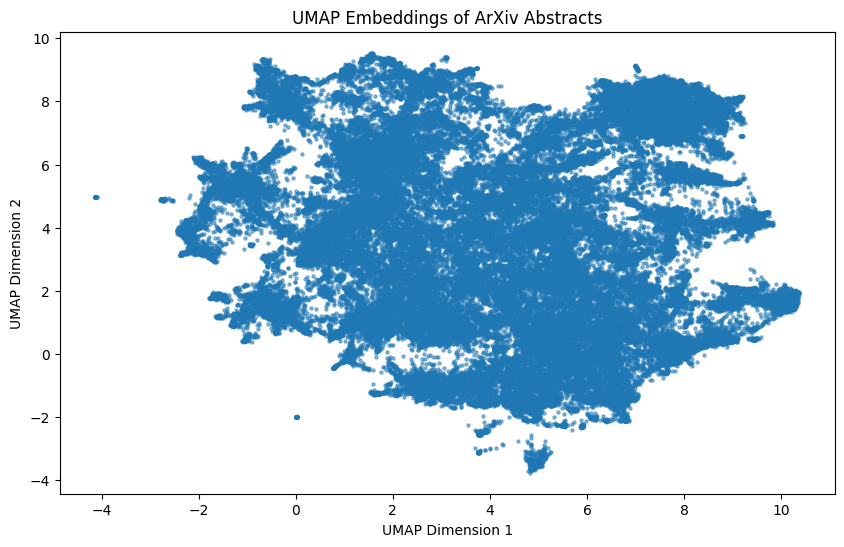

In [29]:
# UMAP
import umap
import matplotlib.pyplot as plt

# Create UMAP model
umap_model = umap.UMAP(n_components=2, random_state=42)

# Fit the model to the abstract embeddings
umap_embeddings = umap_model.fit_transform(abstract_embeddings)

# Plot the UMAP embeddings
plt.figure(figsize=(10, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5, alpha=0.5)
plt.title('UMAP Embeddings of ArXiv Abstracts')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()